In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
import json
from pathlib import Path
from utils import create_directory
from model import test
import plot as plot
import numpy as np
import matplotlib.pyplot as plt
from utils import optimize_channel

In [2]:
model_num = 5
model_name = "model{:02d}".format(model_num)
data_dir = create_directory(directory_name='finetune10')


# some sanity checks
#fig, ax = plot.plot_activation(data[0]['all_hidden'],data[0]['all_muscle'])
#log_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_log.json'))[0]
#log = json.load(open(log_file,'r'))
#fig,ax = plot.plot_training_log(log,'position',w=1)

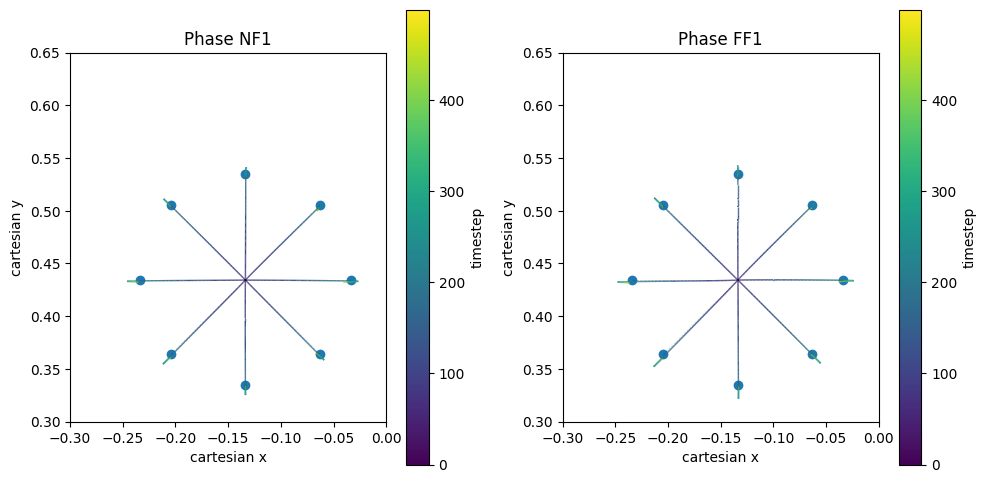

In [19]:
data=[]
label = ['NF1','FF1']
ff = [0,8]
is_channel = True
K = 870
B = -5

fig,ax = plt.subplots(1,2,figsize=(10,5))
for i,p in enumerate(label):
    weight_file = list(Path(data_dir).glob(f'{model_name}_phase={p}_*_weights'))[0]
    cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={p}_*_cfg.json'))[0]
    data.append(test(cfg_file,weight_file,ff_coefficient=ff[i],is_channel=is_channel,K=K,B=B))
    plot.plot_simulations(ax[i],xy=data[i]['xy'],target_xy=data[i]['tg'],vel=None,plot_lat=False)
    ax[i].set_title(f'Phase {p}')

plt.tight_layout()
plt.show()

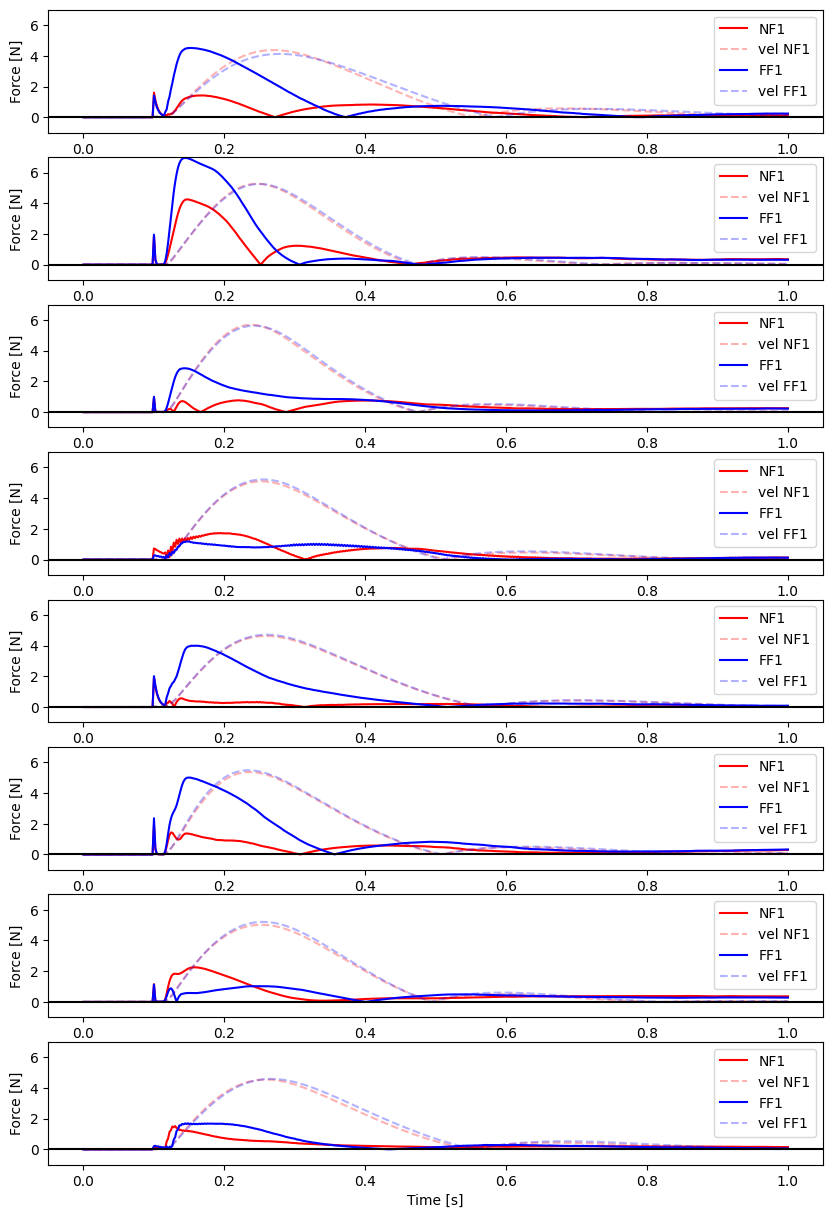

In [20]:
fig, ax = plot.plot_force(data,label)

In [5]:
i=1
fig,ax = plot_speed(data[0]['vel'],data[i]['xy'],data[i]['tg'],figsize=(5,20))

NameError: name 'data' is not defined

In [21]:
def plot_force(data,label,figsize=(10,15)):
    fg, ax = plt.subplots(nrows=8,ncols=1,figsize=figsize)


    vel1 = np.array(data[0]['vel'])
    vel2 = np.array(data[1]['vel'])

    xy = np.array(data[0]['xy'])
    target = np.array(data[0]['tg'])
    target = target[:,-1,:]
    init = xy[:,0,:]


    line_vector = target - init
    line_vector2 = np.tile(line_vector[:,None,:],(1,vel1.shape[1],1))

    projection1 = np.sum(line_vector2 * vel1, axis=-1)/np.sum(line_vector2 * line_vector2, axis=-1)
    projection2 = np.sum(line_vector2 * vel2, axis=-1)/np.sum(line_vector2 * line_vector2, axis=-1)
    projection1 = line_vector2 * projection1[:,:,np.newaxis]
    projection2 = line_vector2 * projection2[:,:,np.newaxis]




    color_list = ['r','b','g','c','m','y','k','orange']

    #x = np.linspace(0, 1, 100)
    x = np.linspace(0, 1, np.shape(data[0]['all_endpoint'])[1])

    for i in range(8):
        ep1 = np.linalg.norm(data[0]['all_endpoint'][i,:,:],axis=1)
        ep2 = np.linalg.norm(data[1]['all_endpoint'][i,:,:],axis=1)
        diff = ep2-ep1

        pv1 = np.linalg.norm(projection1[i,:,:],axis=1)
        
        ax[i].plot(x,diff,color=color_list[0],label=label[0])
        ax[i].plot(x,10*pv1,color=color_list[1],label=label[0])
        
        ax[i].axhline(y=00, color='k')

        ax[i].set_ylabel('Force [N]')
        ax[i].set_ylim([-5,7])
        if i==7:
            ax[i].set_xlabel('Time [s]')
        ax[i].legend()
    return fg, ax


In [3]:
def plot_speed(vel,xy,target,figsize=(10,15)):
    """endpoint speed
    """
    vel = np.array(vel)
    xy = np.array(xy)
    target = np.array(target)
    target = target[:,-1,:]
    init = xy[:,0,:]


    line_vector = target - init
    line_vector2 = np.tile(line_vector[:,None,:],(1,vel.shape[1],1))

    projection = np.sum(line_vector2 * vel, axis=-1)/np.sum(line_vector2 * line_vector2, axis=-1)
    projection = line_vector2 * projection[:,:,np.newaxis]

    lat_speed = vel - projection

    vel = lat_speed
    #vel = projection


    fg, ax = plt.subplots(nrows=8,ncols=1,figsize=figsize)

    color_list = ['blue','orange']

    #x = np.linspace(0, 1, 100)
    x = np.linspace(0, 1, np.shape(data[0]['all_endpoint'])[1])

    for i in range(8):
        ax[i].plot(x,vel[i,:,0],color=color_list[0],label='x')
        ax[i].plot(x,vel[i,:,1],color=color_list[1],label='y')

        ax[i].axhline(y=0, color='k')

        ax[i].set_ylabel('velocity [m/s]')
        #ax[i].set_ylim([-1,7])
        if i==7:
            ax[i].set_xlabel('Time [s]')
        ax[i].legend()
    return fg, ax


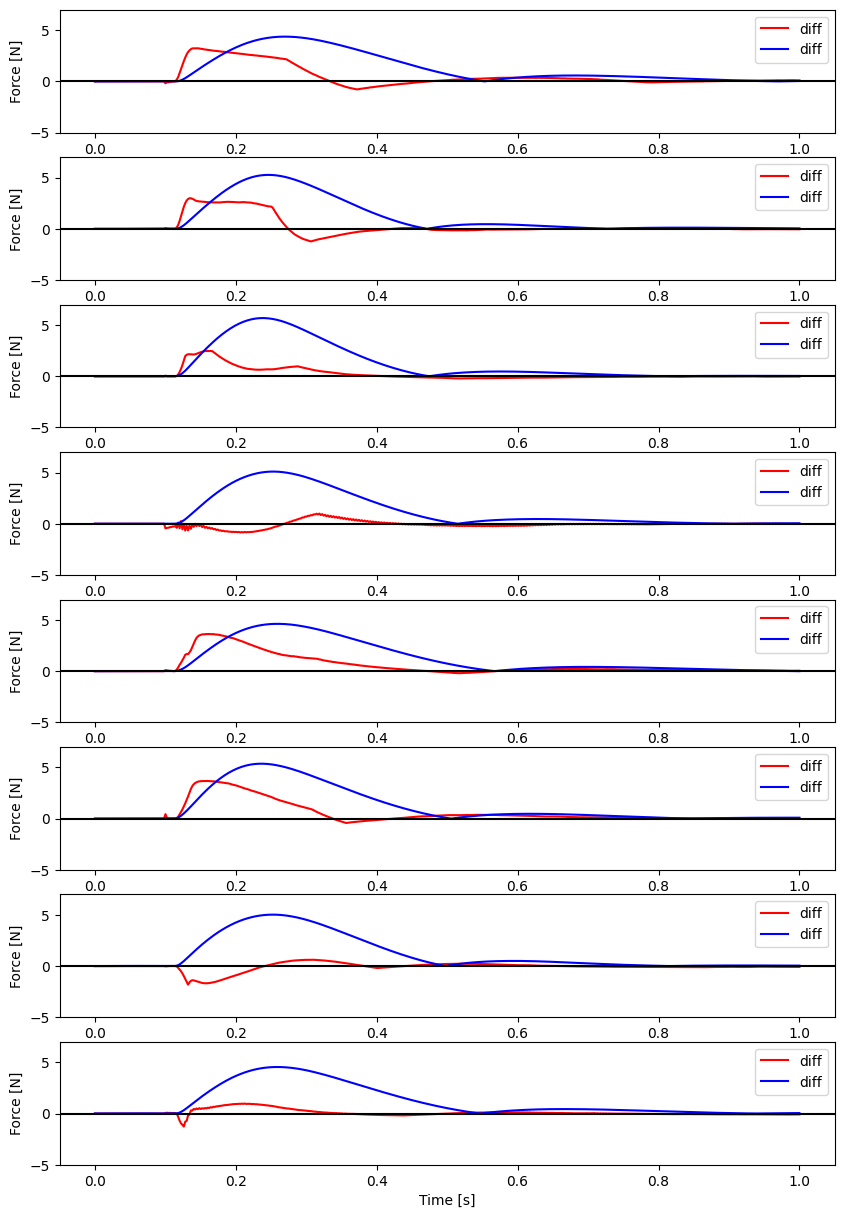

In [22]:
#fig, ax = plot.plot_force(data,label)
fig, ax = plot_force(data,['diff','vel'])